# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 09/14/2021

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
!pip uninstall statsmodels
!pip install statsmodels
!pip install geopandas
import geopandas as gpd #to work with spatial data
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels import tsa
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.distributions import empirical_distribution
import seaborn as sns
import scipy
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

Found existing installation: statsmodels 0.10.2
Uninstalling statsmodels-0.10.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.10.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 9.8 MB 17.2 MB/s 
     |████████████████████████████████| 1.0 MB 9.6 MB/s 
     |████████████████████████████████| 6.3 MB 20.4 MB/s 
     |████████████████████████████████| 15.4 MB 60.5 MB/s 
     |████████████████████████████████| 1.4 MB 13.2 MB/s 


In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [13]:
#Import data files

div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
full_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63_WRA_all.csv', parse_dates=['DataDate'], index_col=['DataDate'])
print(div_wd63.dtypes)
print(full_wd63.dtypes)

WaterDistrictNumber             int64
HydrologyID                     int64
DiversionName                  object
DiversionTypeDescription       object
MeasurementTypeDescription     object
CFS                           float64
dtype: object
SiteID           int64
FullName        object
Agency          object
Description     object
CFS            float64
dtype: object


In [20]:
## RENAME THE COLUMNS TO MATCH OLD TIMESERIES DESCRIPTIONS
full_wd63 = full_wd63.rename(columns={'SiteID':'HydrologyID', 'FullName':'DiversionName',
                                      'Description':'DiversionTypeDescription', 'DataDate':'DiversionDate'})

## replace SURPRISE VALLEY/MICRON with surprise_vy_micron to export CSV

full_wd63['DiversionName'] = full_wd63['DiversionName'].replace(to_replace='SURPRISE VALLEY/MICRON',
                                                                value='SURPRISE_VALLEY_MICRON')

In [21]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

div_name = np.unique(full_wd63['DiversionName']) #get unique identifier for each div point
print(div_name)

for n in div_name:
  canal = full_wd63[full_wd63['DiversionName']== n] #creates a dataframe for each canal name
  canal = canal.sort_index() #sorts data by date
  file_name = 'datasets/diversion_timeseries/fulltime_individual_canals/'+ str(n) +'.csv' #creates a file path
  canal.to_csv(file_name) #exports csv to directory

['ANDERSON RANCH RESERVOIR AT ANDERSON RANCH DAM' 'ARROWROCK RESERVOIR'
 'ATWELL' 'BALLENTYNE CANAL' 'BARBER PUMPS' 'BOISE CITY CANAL'
 'BOISE CITY PARKS' 'BOISE RIVER AT ARROWROCK DAM'
 'BOISE RIVER AT GLENWOOD BRIDGE' 'BOISE RIVER AT LUCKY PEAK DAM'
 'BOISE RIVER AT VETERANS MEMORIAL PARKWAY'
 'BOISE RIVER BELOW DIVERSION DAM' 'BOISE RIVER NEAR MIDDLETON'
 'BOISE RIVER NEAR TWIN SPRINGS'
 'BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION)' 'BUBB CANAL'
 'BUREAU OF RECLAMATION INSTREAM FLOW RELEASE' 'CALDWELL HIGHLINE CANAL'
 'CAMPBELL CANAL' 'CANYON COUNTY CANAL'
 'CAPITOL VIEW PUMP (INCLUDED IN FARMERS UNION)' 'CONWAY-HAMMING CANAL'
 'CRUZEN (CONSUMERS)' 'Caldwell Lowline Canal' 'DISCOVERY PARK'
 'DIVERSION DAM' 'DRAINAGE DISTRICT #3' 'EAGLE DRAIN' 'EAGLE ISLAND PARK'
 'ESTER SPIMPLOT PIPE' 'EUREKA #1 CANAL (INCLUDED IN PHYLLIS)' 'EUREKA #2'
 'FAIRVIEW ACRES' 'FARMERS UNION CANAL'
 'FISH AND GAME INSTREAM FLOW RELEASE' 'FIVEMILE CREEK' 'GOLDEN GATE'
 'GRAHAM-GILBERT CANAL' 'GREEN RANCH

In [23]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###


all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/fulltime_individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DataDate'], index_col=['DataDate'])
  all_files.append(df) #appends dataframes to one file list

In [26]:
## WILL DELETE LATER ## 
## Helps know the number to call for mini analysis

canal_list = []

for i in range(len(all_files)):
  canal = all_files[i]
  canal_list.append(canal['DiversionName'][1])

canal_list = pd.DataFrame(canal_list)
print(canal_list)

                                                  0
0    ANDERSON RANCH RESERVOIR AT ANDERSON RANCH DAM
1                               ARROWROCK RESERVOIR
2                                            ATWELL
3                                  BALLENTYNE CANAL
4                                      BARBER PUMPS
..                                              ...
103                                WILDERNESS RANCH
104                                   WILLIAMS PARK
105                       WILLOW CREEK AT MIDDLETON
106                                           WOODS
107                         zz--Unidentified Site--

[108 rows x 1 columns]


In [ ]:
#Plot the data to see the timescale

###----------------------------------###
### CREATES ONE FIGURE FOR ALL PLOTS ###
###----------------------------------###

len(all_files)
i,j = 0,0
plot_row = 4 #number of plots per row in figure
figure, ax = plt.subplots(33, plot_row, figsize=(30,150)) #create the figure
file_len = np.array(np.arange(0,len(all_files),1)) #total count of files

for f in file_len: #run a for loop to add all plots to figure
  canal_data = all_files[f] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'], 'o')
  ax[i][j].set_ylabel('Discharge (cfs)')
  ax[i][j].set_xlabel('Time')
  ax[i][j].title.set_text(canal_data['DiversionName'].iloc[0])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

###---------------------------------------------###
### CREATES INDIVIDUAL PLOTS FOR EACH DIVERSION ###
###---------------------------------------------###

for f in file_len:
  canal_data = all_files[f]
  fig = plt.figure(figsize= (9,7))
  ax = fig.add_subplot(1,1,1)
  ax.plot(canal_data.index, canal_data['CFS'], 'o')
  ax.set_ylabel('Discharge (cfs)')
  ax.set_xlabel('Time')
  ax.title.set_text(canal_data['DiversionName'].iloc[0])
  file_path = ('datasets/diversion_timeseries/individualplots/'+ canal_data['DiversionName'].iloc[0] +'.png')
  plt.savefig(file_path) #exports the file 


In [49]:
## EXPLORATORY DATA ANALYSIS ##

## Start with 4 known canals: Ridenbaugh, Settlers, Phyllis, Riverside

main_canals = ([all_files[71], all_files[93], all_files[80], all_files[73]])  #subset to the 4 canals
years = np.array(np.arange(1985,2021,1)) #creates an array for the years
totals = np.empty((len(years), len(main_canals))) #create an empty vector to store sums
names = []
for i in range(len(main_canals)):
  sub_canal = main_canals[i]['DiversionName']
  names.append(sub_canal[1])
print(names)

['RIDENBAUGH CANAL', 'THURMAN DRAIN', 'SETTLERS CANAL', 'RIVERSIDE CANAL']


In [41]:
## QAQC on data

# 1) Make series from Jan 1 2003 to start date of irrigation season and append series
#    to dataframes

dt_series = pd.date_range(start='2003-01-01', end='2003-03-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canals = []

for i in range(len(main_canals)):
  canal = main_canals[i]
  canal = pd.concat([dt_df, canal])
  canal = canal.asfreq('d')
  canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
  canal['DiversionName'] = canal['DiversionName'].fillna(names[i]) #fills Nan diversion name values
  canals.append(canal)


In [44]:
## IMPORT RESERVOIR FILL FILE TO NORMALIZE DIVERTED VOLUME TO AVAILABLE WATER ##
## -------------------------------------------------------------------------- ##
## Try two metrics: 
##       1) Max reservoir fill
##       2) Fill at the earliest start of the irrigation season
## -------------------------------------------------------------------------- ##

fill = pd.read_csv('datasets/diversion_timeseries/reservoir_fill.csv', parse_dates=['Date'], index_col=['Date'])

## Find the max fill every year

max_fill = []

for i in range(len(years)):
  data = fill[fill.index.year == years[i]]
  max_fill.append([years[i], np.max(data['TotalStorage'])])

max_fill = pd.DataFrame(max_fill, columns = ['Year', 'MaxFill'])

## FIND THE FILL AT THE EARLIEST START OF EACH IRRIGATION SEASON ##

## Find the daily cumulative sum over the irrigation season to detect start of irrigation season

for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

# ##Find the start date for each canal based on cumulative sum 

# starts = []

# for i in range(len(canals)):
#   for y in range(len(years)):
#     canal_data = canals[i]
#     canal_name = canal_data['DiversionName'][1]
#     canal_by_year = canal_data[canal_data.index.year == years[y]]
#     min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
#     min_Ix = min_Ix[0]
#     min_Ix = min_Ix[-1]
#     start_date = canal_by_year.index[min_Ix]
#     start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
#     starts.append([canal_name, start_date, start_dayofyear])

# starts = pd.DataFrame(starts, columns = ['Name', 'StartDate', 'StartDayofYear']).set_index('StartDate')

# ## Find the earliest day for start of irrigation season across all canals

# start_irrseason = []

# for i in range(len(years)):
#   year_vals = starts[starts.index.year == years[i]]
#   start_irrseason.append(year_vals.index.min())

# start_irrseason = pd.Series(start_irrseason)

# # Find the fill at the earliest start date of the irrigation season

# start_fill = []

# for i in range(len(years)):
#   early_start = start_irrseason[i]
#   data = int(fill['TotalStorage'][fill.index.date == early_start])
#   start_fill.append([years[i], data])

# start_fill = pd.DataFrame(start_fill, columns = ['Year', 'StartFill'])




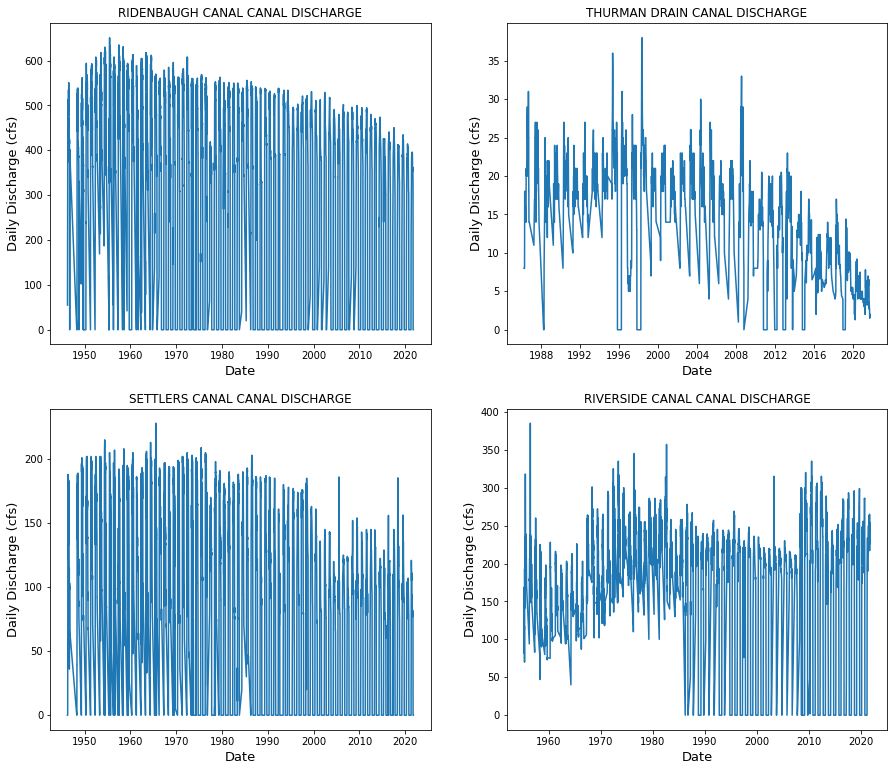

In [50]:
## PLOT THE RAW DATA TO VISUALLY ANALYZE TRENDS AND SEASONALITY

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15,13)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = main_canals[n] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'])
  ax[i][j].set_ylabel('Daily Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Date', size=13)
  ax[i][j].title.set_text(names[n]+' CANAL DISCHARGE')
  # ax[i][j].set_xticks(years)
  # ax[i][j].set_xticklabels(years, rotation=45)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/rawdata.png')


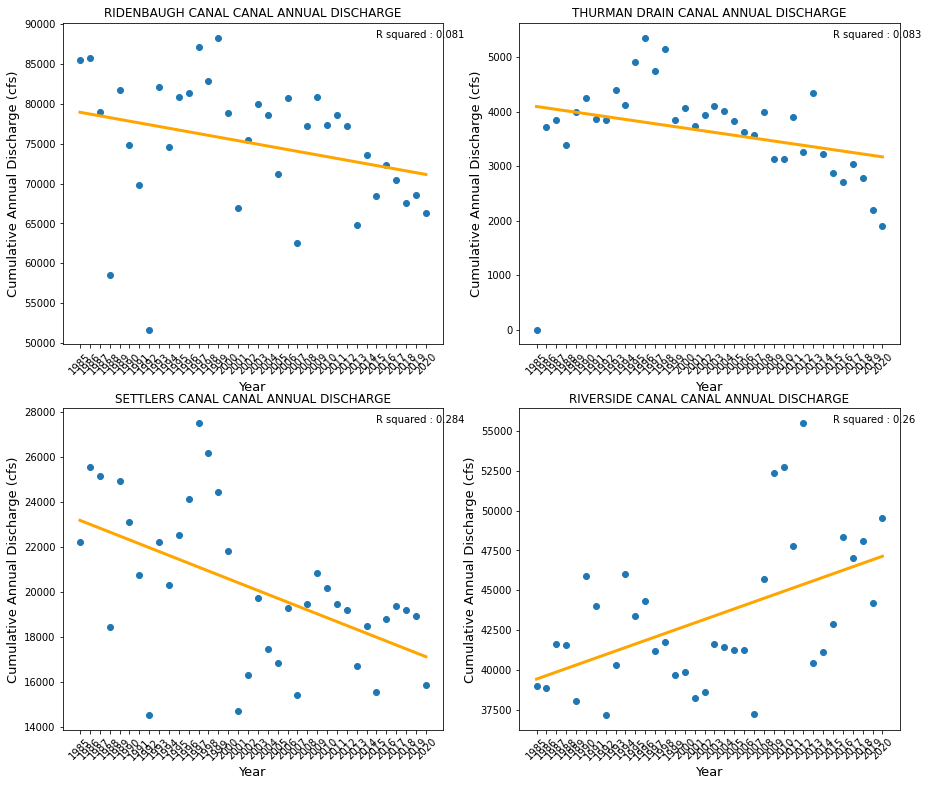

In [51]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

for i in range(len(canals)):
  for y in range(len(years)):
    sub_canal = main_canals[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['CFS']) #sum the total discharge throughout the year
    #need to find a way to normalize the total for the year

## CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(totals[:,i], regression[:,i]) #compares correlation of model to true values


## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15,13)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' CANAL ANNUAL DISCHARGE')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2015, np.max(totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

In [52]:
## Normalize total water diverted to the max fill available that year

norm_totals = np.empty((len(years), len(canals)))

for y in range(len(years)):
  for i in range(len(canals)):
    cum_discharge = totals[y][i]
    res_fill = max_fill['MaxFill'][max_fill['Year'] == years[y]]
    norm_totals[y][i] = cum_discharge/res_fill

# CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, norm_totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(norm_totals[:,i], regression[:,i]) #compares correlation of model to true values


## Plot the normalized discharges

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15, 13)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = norm_totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Normalized Annual Discharge (cfs / KAF)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' CANAL NORMALIZED ANNUAL DISCHARGE')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2015, np.max(norm_totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/norm_totals.png')


ValueError: ignored

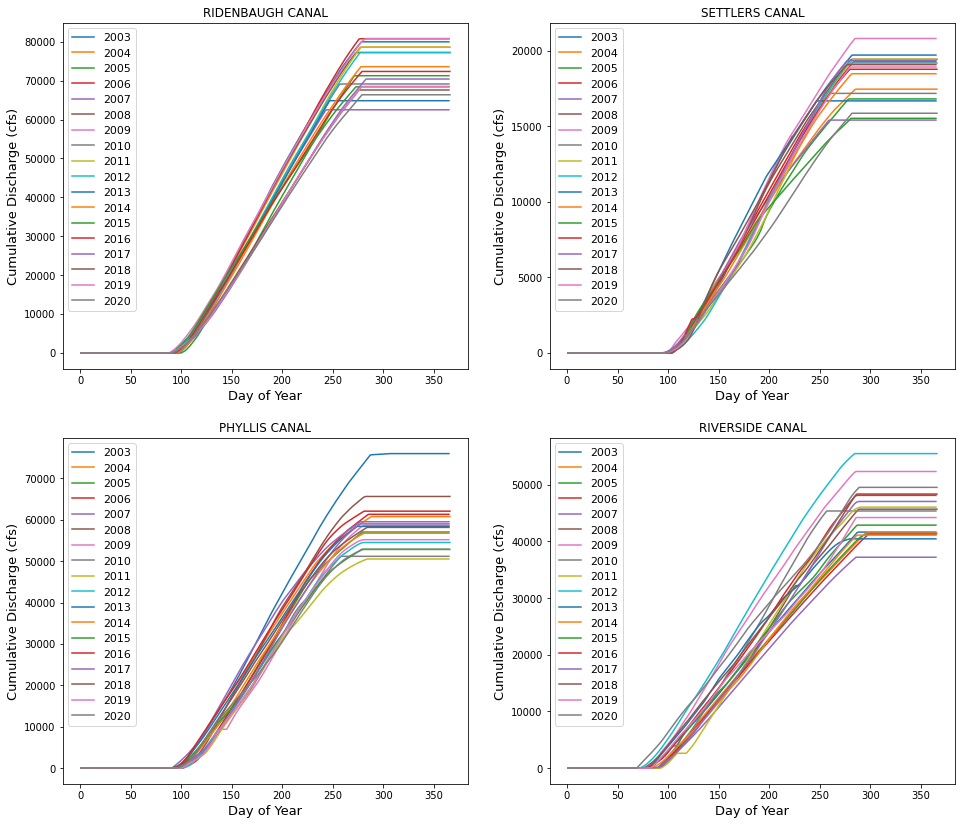

In [ ]:
## CUMULATIVE SUMS DAILY ##

#Create a loop to sum the total water diverted for every year

years = np.array(np.arange(2003,2021,1)) #creates an array for the years
cumsum_years = []

for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    Ix = sub_canal.index.year == years[j] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    series_cfs = pd.Series(subset_year['CFS'])
    cumsum_daily = series_cfs.cumsum()
    cumsum_years.append(cumsum_daily)

#Plot the cumulative sum by the day of year

year = np.array(np.arange(0,72,1))
fig3 = plt.figure(figsize = (16,14))
ax = fig3.add_subplot(2,2,1)
ax1 = fig3.add_subplot(2,2,2)
ax2 = fig3.add_subplot(2,2,3)
ax3 = fig3.add_subplot(2,2,4)
for i in range(len(year)):
  if year[i]<18:
    ax.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax.legend(years, fontsize=11)
    ax.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax.set_xlabel('Day of Year', size=13)
    ax.set_title(names[0]+' CANAL') #add the name of the canal
  elif year[i]<36:
    ax1.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax1.legend(years, fontsize=11)
    ax1.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax1.set_xlabel('Day of Year', size=13)
    ax1.set_title(names[1]+' CANAL')
  elif year[i]<54:
    ax2.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax2.legend(years, fontsize=11)
    ax2.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax2.set_xlabel('Day of Year', size=13)
    ax2.set_title(names[2]+' CANAL')
  else:
    ax3.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax3.legend(years, fontsize=11)
    ax3.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax3.set_xlabel('Day of Year', size=13)
    ax3.set_title(names[3]+' CANAL')
plt.legend(years, fontsize=11)
plt.savefig('datasets/diversion_timeseries/figures/cumsum.png')
plt.show()

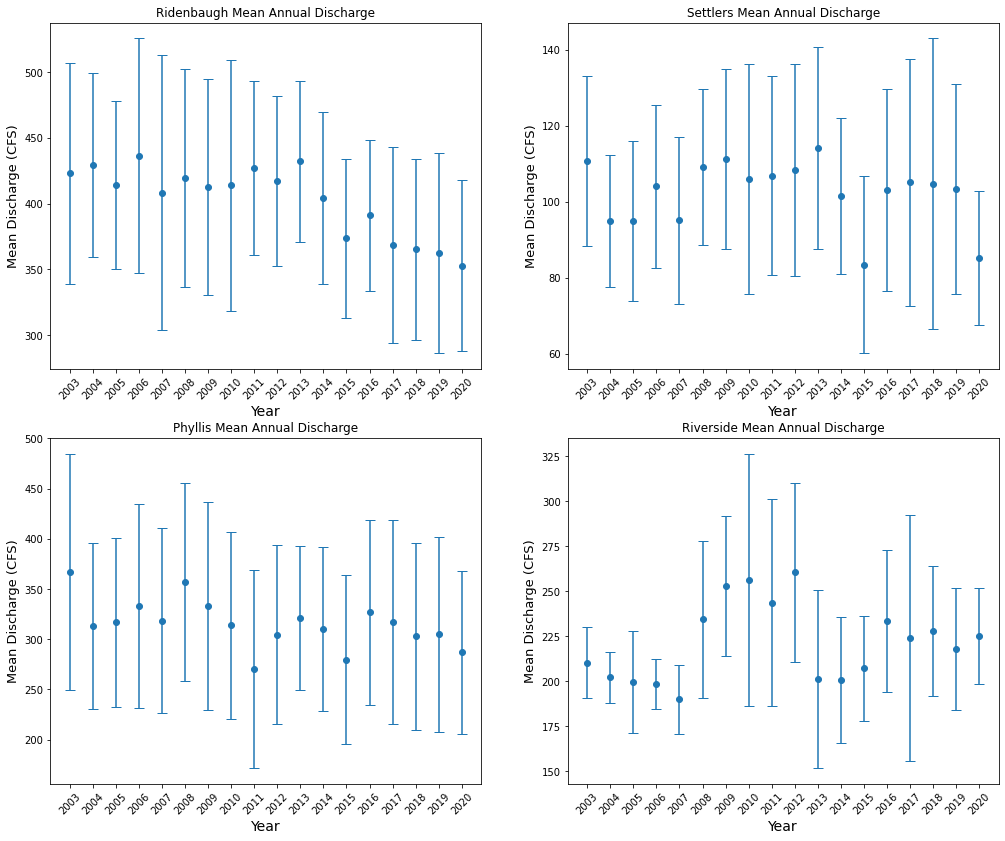

In [ ]:
## FIND THE MEAN AND STD DEVIATION ACROSS THE YEARS FOR EACH CANAL

mean_vector = np.empty((len(years), len(canals)))
std_vector = np.empty((len(years), len(canals)))

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    mean_vector[i][n] = np.mean(year['CFS'][year['CFS'] != 0])
    std_vector[i][n] = np.std(year['CFS'][year['CFS'] != 0])

fig6 = plt.figure(figsize=(17,14))
ax = fig6.add_subplot(2,2,1)
ax1 = fig6.add_subplot(2,2,2)
ax2 = fig6.add_subplot(2,2,3)
ax3 = fig6.add_subplot(2,2,4)
ax.errorbar(years, mean_vector[:,0], yerr=std_vector[:,0], fmt='o', capsize=5)
ax.set_ylabel('Mean Discharge (CFS)', size=13)
ax.set_xlabel('Year', size=14)
ax.set_title('Ridenbaugh Mean Annual Discharge')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
ax1.errorbar(years, mean_vector[:,1], yerr=std_vector[:,1], fmt='o', capsize=5)
ax1.set_ylabel('Mean Discharge (CFS)', size=13)
ax1.set_xlabel('Year', size=14)
ax1.set_title('Settlers Mean Annual Discharge')
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)
ax2.errorbar(years, mean_vector[:,2], yerr=std_vector[:,2], fmt='o', capsize=5)
ax2.set_ylabel('Mean Discharge (CFS)', size=13)
ax2.set_xlabel('Year', size=14)
ax2.set_title('Phyllis Mean Annual Discharge')
ax2.set_xticks(years)
ax2.set_xticklabels(years, rotation=45)
ax3.errorbar(years, mean_vector[:,3], yerr=std_vector[:,3], fmt='o', capsize=5)
ax3.set_ylabel('Mean Discharge (CFS)', size=13)
ax3.set_xlabel('Year', size=14)
ax3.set_xticks(years)
ax3.set_xticklabels(years, rotation=45)
ax3.set_title('Riverside Mean Annual Discharge')
plt.savefig('datasets/diversion_timeseries/figures/meandischarge.png')
plt.show()



In [ ]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(canals)):
  canal = canals[i]
  avg = np.mean(canal['CFS'][canal['CFS'] != 0])
  std_dev = np.std(canal['CFS'][canal['CFS'] != 0])
  avg_withzero = np.mean(canal['CFS'])
  std_withzero = np.std(canal['CFS'])
  coeff_var = std_dev/avg
  coeff_var_withzero = std_withzero/avg_withzero
  maximum = np.max(canal['CFS'])
  minimum = np.min(canal['CFS'][canal['CFS'] != 0])
  stats.append([names[i], avg, std_dev, coeff_var, maximum, minimum, avg_withzero, std_withzero, coeff_var_withzero])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Mean', 'Standard_dev', 
                                            'Coefficient_Variation', 'Maximum', 'Minimum', 
                                            'Mean_ZeroValues', 'Standard_dev_ZeroValues',
                                            'Coefficient_ZeroValues'])


display(base_stats)
base_stats.to_csv('datasets/diversion_timeseries/figures/stats.csv')



,DiversionName,Mean,Standard_dev,Coefficient_Variation,Maximum,Minimum,Mean_ZeroValues,Standard_dev_ZeroValues,Coefficient_ZeroValues
0,RIDENBAUGH,399.855664,79.522865,0.198879,518.0,5.00,199.576259,207.671368,1.040561
1,SETTLERS,101.681740,26.444748,0.260074,186.0,0.36,49.931933,54.105258,1.083580
2,PHYLLIS,314.984036,95.116853,0.301974,483.0,16.70,160.584622,171.483549,1.067870
3,RIVERSIDE,221.367792,44.879122,0.202736,335.0,1.80,124.146328,114.887966,0.925424


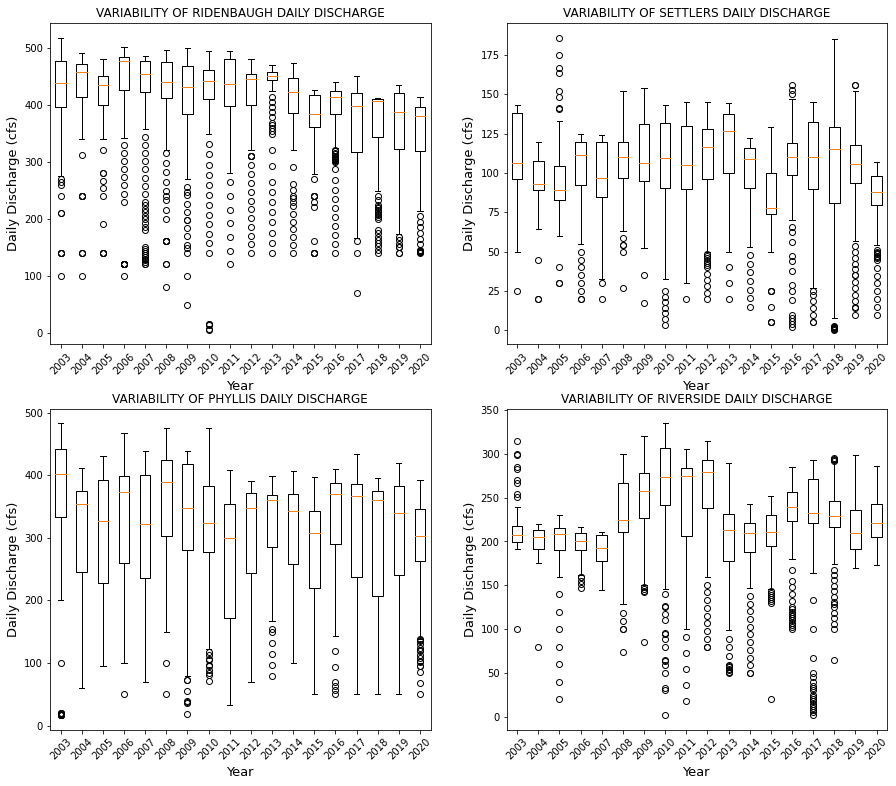

In [ ]:
## Create boxplot to show daily variability across the years

box_array = []

# Ridenbaugh canal
canal = canals[0]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array.append(cfs_year)

#Settlers Canal
box_array1 = []
canal = canals[1]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array1.append(cfs_year)

# Phyllis Canal
box_array2 = []
canal = canals[2]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array2.append(cfs_year)

# Riverside Canal 
box_array3 = []
canal = canals[3]
canal = canal[~((canal.index.month == 2) & (canal.index.day == 29))]
for y in range(len(years)):
  canal_year = canal[canal.index.year==years[y]]
  cfs_year = np.array(canal_year['CFS'][canal_year['CFS'] != 0])
  box_array3.append(cfs_year)

box_array_rid = np.array(box_array, dtype='object')
box_array_set = np.array(box_array1, dtype='object')
box_array_phyl = np.array(box_array2, dtype='object')
box_array_riv = np.array(box_array3, dtype='object')

fig, ax = plt.subplots(2, plot_row, figsize=(15,13))

ax[0][0].boxplot(box_array_rid)
ax[0][0].set_title('VARIABILITY OF '+ names[0]+' DAILY DISCHARGE')
ax[0][0].set_xlabel('Year', size=13)
ax[0][0].set_ylabel('Daily Discharge (cfs)', size=13)
ax[0][0].set_xticklabels(years, rotation=45)
ax[0][1].boxplot(box_array_set)
ax[0][1].set_title('VARIABILITY OF '+ names[1]+' DAILY DISCHARGE')
ax[0][1].set_xlabel('Year', size=13)
ax[0][1].set_ylabel('Daily Discharge (cfs)', size=13)
ax[0][1].set_xticklabels(years, rotation=45)
ax[1][0].boxplot(box_array_phyl)
ax[1][0].set_title('VARIABILITY OF '+ names[2]+' DAILY DISCHARGE')
ax[1][0].set_xlabel('Year', size=13)
ax[1][0].set_ylabel('Daily Discharge (cfs)', size=13)
ax[1][0].set_xticklabels(years, rotation=45)
ax[1][1].boxplot(box_array_riv)
ax[1][1].set_title('VARIABILITY OF '+ names[3]+' DAILY DISCHARGE')
ax[1][1].set_xlabel('Year', size=13)
ax[1][1].set_ylabel('Daily Discharge (cfs)', size=13)
ax[1][1].set_xticklabels(years, rotation=45)



plt.savefig('datasets/diversion_timeseries/figures/boxplot_variable.png')


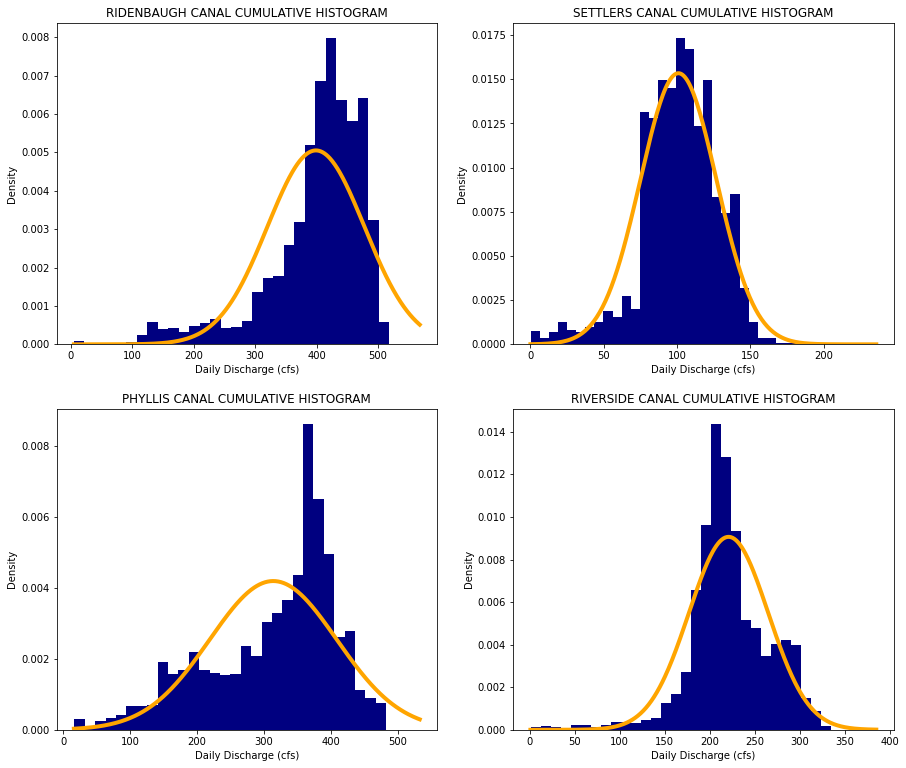

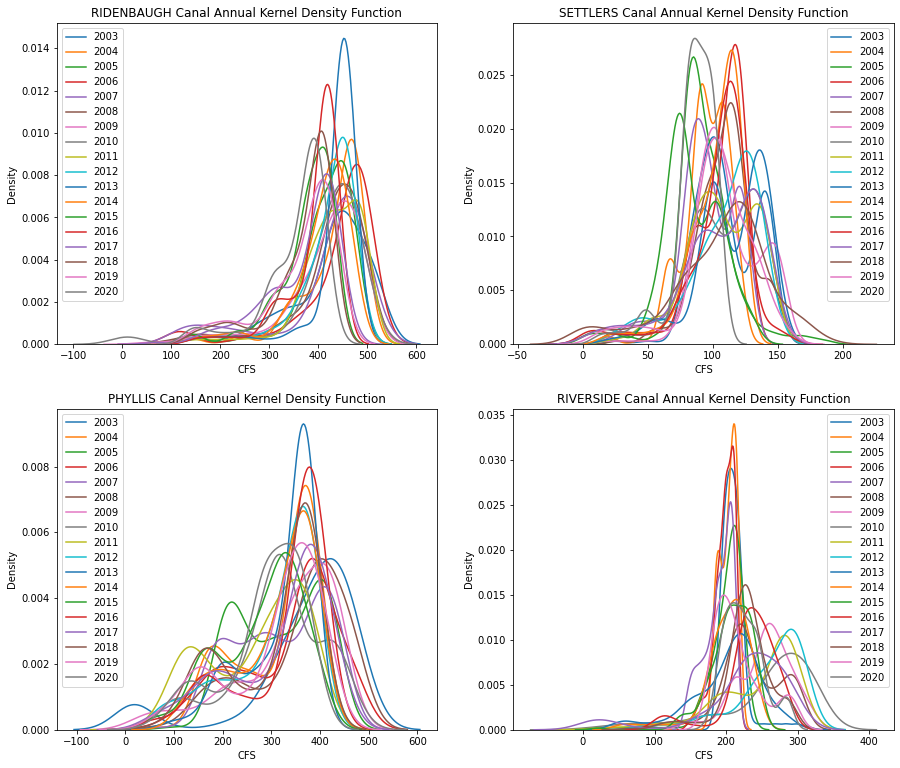

In [ ]:
## plot the KDE per year with the normal distribution over the top

#Define a normal PDF function
def mynormpdf(x, mean, std): 
  A = 1/(std*np.sqrt(2*np.pi))
  B = (x-mean)**2
  C = 2*std**2
  f = A*np.exp(-B/C)
  return f #returns the probability density for x, the mean of x, and the std dev of x 

## Plot the total histrogram of discharge with a normal pdf overlay 

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15, 13)) #create the figure

for n in range(len(canals)):
  max_canal, min_canal = [int(base_stats['Maximum'][base_stats['DiversionName'] == names[n]]), 
                          int(base_stats['Minimum'][base_stats['DiversionName'] == names[n]])]
  # Create a linespace of the max and min diversion rate for each canal and set the normal distribution to that range
  x_vals = np.linspace(min_canal, max_canal+50, num = (max_canal+50-min_canal))
  # Creat the normal distribution using total mean and total std deviation
  normal_pdf = mynormpdf(x_vals, int(base_stats['Mean'][base_stats['DiversionName'] == names[n]]), 
                         int(base_stats['Standard_dev'][base_stats['DiversionName'] == names[n]]))
  canal = canals[n]
  ax[i][j].hist(canal['CFS'][canal['CFS'] != 0], bins=30, density=True, cumulative=False, color = 'navy')
  ax[i][j].plot(x_vals, normal_pdf, color = 'orange', linewidth = 4)
  ax[i][j].set_title(str(names[n])+' CANAL CUMULATIVE HISTOGRAM')
  ax[i][j].set_ylabel('Density')
  ax[i][j].set_xlabel('Daily Discharge (cfs)')
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

plt.savefig('datasets/diversion_timeseries/figures/histogram')
plt.show()

## Plot the yearly KDE with legend to select years that are similar and group them together

del ax

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, axis = plt.subplots(2, plot_row, figsize=(15, 13)) #create the figure

for n in range(len(canals)):
  axis[i][j].set_title(str(names[n])+' Canal Annual Kernel Density Function')
  for y in range(len(years)):
    canal = canals[n]
    canal = canal[canal.index.year == years[y]]
    sns.kdeplot(canal['CFS'][canal['CFS'] != 0], cumulative=False, ax=(axis[i][j]))
    axis[i][j].legend(years)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

plt.savefig('datasets/diversion_timeseries/figures/kde.png')
plt.show()


In [ ]:
## Calcualte the kernel density estimate for each year in a canal and compare between years using RMSE 

dx = 0.5 #step change
x = np.arange(0, 600, dx) #xrange to create kde over
h = 20 #window size
kdf = np.empty((len(canals), len(x), len(years)))

## Create the kde over x for each year of a canal

for i in range(len(canals)):
  for y in range(len(years)):
    canal = canals[i]
    canal_year = canal[canal.index.year == years[y]]
    nc, xbins, patches = plt.hist(canal_year['CFS'][canal_year['CFS'] != 0], 30)
    plt.close()
    for n in range(len(x)):
      x0 = x[n].copy()
      w = scipy.stats.norm.pdf(canal_year['CFS'][canal_year['CFS'] != 0], x0, h)
      kdf[i][n][y] = np.sum(w)
      kdf[i,:,y] = kdf[i, :, y]/(np.sum(kdf[i, :, y]*dx))

## Calculate the RMSE between each year within a canal

rmse = []

for i in range(len(canals)):
  pdfs = kdf[i,:,:]
  for y in range(len(years)):
    kdf_year = pdfs[:,y]
    for n in range(len(years)):
      compare = pdfs[:,n]
      rmse_samp = np.sqrt(np.mean((kdf_year-compare)**2))
      rmse.append([names[i], years[y], years[n], rmse_samp])

rmse = pd.DataFrame(rmse, columns=['Name', 'YearSelect', 'YearCompare', 'RMSE'])

##Want to get rid of duplicate years (like getting rid of half of a correlation matrix)

new_rmse = []

for i in range(len(canals)):
  rid = rmse[rmse['Name'] == names[i]]
  # Desired data frame
  new_data = pd.DataFrame()
  # Concat numbers and corresponding letters
  new_data['concat'] = rid[['YearSelect','YearCompare']].apply(lambda r: sorted(r), axis=1)
  rid['combos'] = new_data['concat']
  rid['combostring'] = [','.join(map(str, l)) for l in rid['combos']]
  rid = rid.drop_duplicates(subset='combostring', keep='first', inplace=False)
  del rid['combos']
  del rid['combostring']
  new_rmse.append(rid)

rid = new_rmse[0]
settler = new_rmse[1]
phyllis = new_rmse[2]
riverside = new_rmse[3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


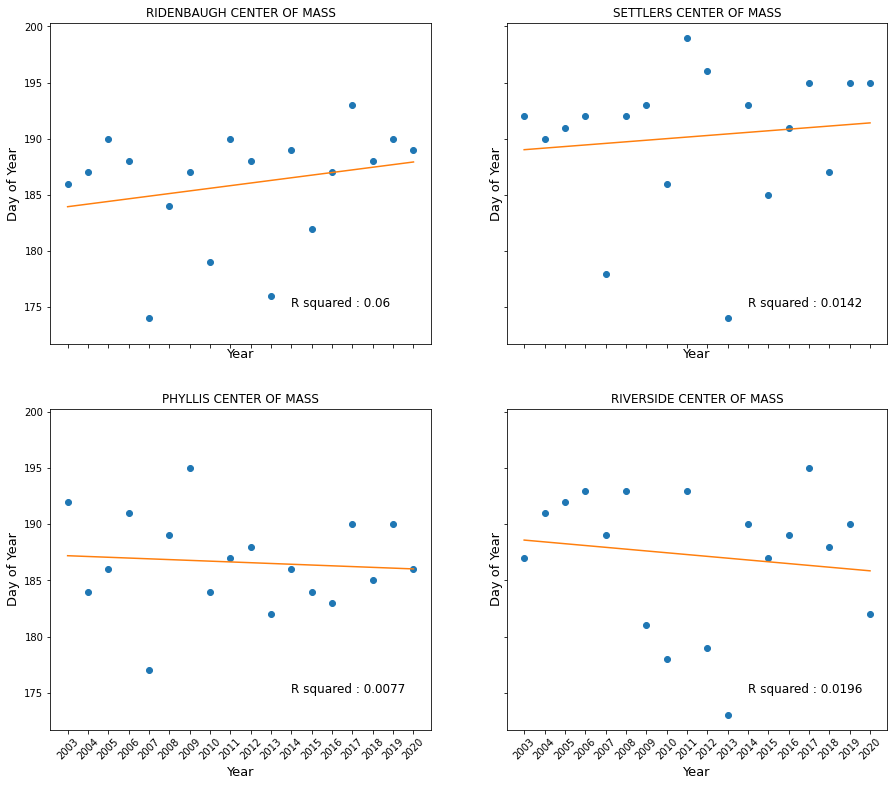

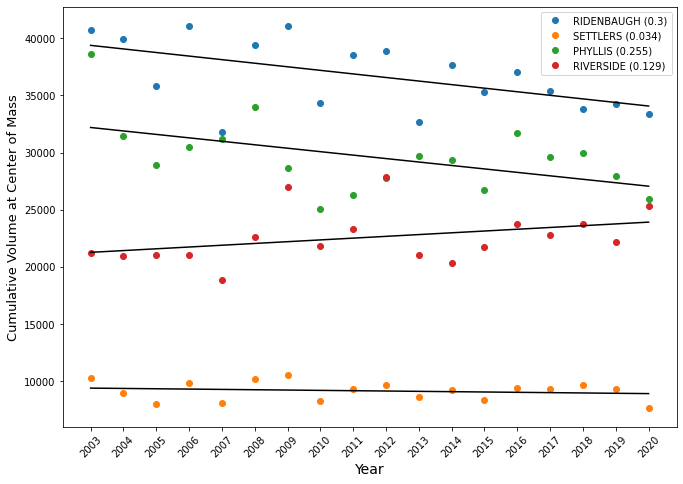

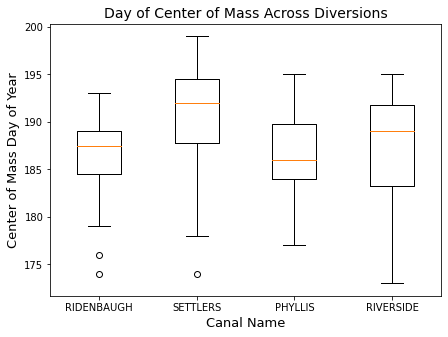

In [ ]:
## FIND THE CENTER OF MASS OF THE IRRIGATION SEASON ##

centroid = np.empty((len(years), len(canals)))
centroid_day = []

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    centroid[i][n] = round(sum(year.index.dayofyear*year['CFS'])/sum(year['CFS']))
    centroid_day.append(centroid[i][n])

## Find the volume at the centroid

centroid_vol = np.empty((len(years), len(canals)))
centroid_volume = []

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    centroid_day = centroid[i][n]
    centroid_vals = year[year.index.dayofyear<=centroid_day]
    centroid_vol[i][n] = sum(centroid_vals['CFS'])
    centroid_volume.append(sum(centroid_vals['CFS']))

## Check to see if there is a trend in the data through time

regression = np.empty((len(years), len(canals)))
r_squared = np.empty(len(canals))

for i in range(len(canals)):
  model = np.polyfit(years, centroid[:,i], deg=1)
  regression [:,i] = np.polyval(model, years)
  r_squared[i] = metrics.r2_score(centroid[:,i], regression[:,i])

regression_vol = np.empty((len(years), len(canals)))
r_squared_vol = np.empty(len(canals))

for i in range(len(canals)):
  model = np.polyfit(years, centroid_vol[:,i], deg=1)
  regression_vol [:,i] = np.polyval(model, years)
  r_squared_vol[i] = metrics.r2_score(centroid_vol[:,i], regression_vol[:,i])

## PLOT THE DAY AT CENTER OF MASS FOR EACH CANAL ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15,13), sharex=True, sharey=True) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = centroid[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n])
  ax[i][j].set_ylabel('Day of Year', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' CENTER OF MASS')
  ax[i][j].tick_params('both')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  ax[i][j].text(2014, 175, s='R squared : ' + str(np.around(r_squared[n], 4)), size=12)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/centroid_time.png')

## PRESENT THE VOLUME AT THE DAY OF CENTER OF MASS FOR EACH CANAL AS A TIMESERIES ##

fig6 = plt.figure(figsize=(11,17))
ax = fig6.add_subplot(2,1,1)
plt.xticks(years, years, rotation= 45)
ax.plot(years, centroid_vol, 'o')
ax.plot(years, regression_vol, color = 'black')
ax.set_ylabel('Cumulative Volume at Center of Mass', size=13)
ax.set_xlabel('Year', size=14)
leg = []
for i in range(len(names)):
  leg.append(names[i] + ' (' + str(np.around(r_squared_vol[i], 3)) + ')')
ax.legend(leg)
plt.savefig('datasets/diversion_timeseries/figures/centroid_vol.png')
plt.show()

# Boxplot comparing center of mass 

fig = plt.figure(figsize= (7,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot(centroid)
ax.set_xticklabels(names)
ax.set_xlabel('Canal Name', size=13)
ax.set_ylabel('Center of Mass Day of Year', size=13)
ax.set_title('Day of Center of Mass Across Diversions', size=14)
plt.savefig('datasets/diversion_timeseries/figures/box_centroid.png')
plt.show()

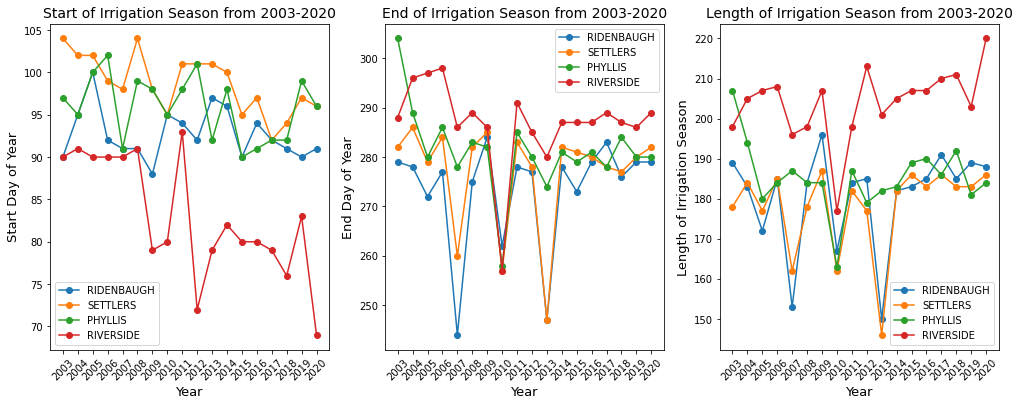

In [ ]:
## PLOT LENGTH OF IRRIGATION SEASON ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

length = []

for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(canals)):
  for y in range(len(years)):
    canal_data = canals[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
    min_Ix = min_Ix[0]
    min_Ix = min_Ix[-1]
    start_date = canal_by_year.index[min_Ix]
    start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
    max_Ix= max_Ix[0]
    max_Ix = max_Ix[0]
    end_date = canal_by_year.index[max_Ix]
    end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    irrig_season_range = end_dayofyear-start_dayofyear
    length.append([canal_name, start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])

season_df = pd.DataFrame(length, columns = ['DiversionName', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range'])
season_df.to_csv('datasets/diversion_timeseries/figures/timing.csv')


## Visualize the start day, end day, and length of irrigation season ##

fig = plt.figure(figsize = (17,6))
ax = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax.plot(years, canal['StartDayofYear'], 'o-')
  ax.legend(names)
  ax.set_ylabel('Start Day of Year', size=13)
  ax.set_xlabel('Year', size=13)
  ax.set_xticks(years)
  ax.set_xticklabels(years, rotation=45)
  ax.set_title('Start of Irrigation Season from 2003-2020', size=14)
for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax1.plot(years, canal['EndDayofYear'], 'o-')
  ax1.legend(names)
  ax1.set_ylabel('End Day of Year', size=13)
  ax1.set_xlabel('Year', size=13)
  ax1.set_xticks(years)
  ax1.set_xticklabels(years, rotation=45)
  ax1.set_title('End of Irrigation Season from 2003-2020', size=14)
for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax2.plot(years, canal['Range'], 'o-')
  ax2.legend(names)
  ax2.set_ylabel('Length of Irrigation Season', size=13)
  ax2.set_xlabel('Year', size=13)
  ax2.set_xticks(years)
  ax2.set_xticklabels(years, rotation=45)
  ax2.set_title('Length of Irrigation Season from 2003-2020', size=14)

plt.savefig('datasets/diversion_timeseries/figures/timing_stats.png')
plt.show()


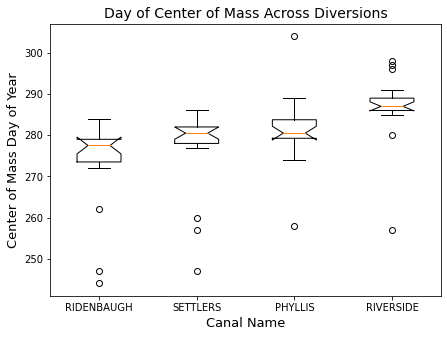

In [ ]:
fig = plt.figure(figsize= (7,5))
ax = fig.add_subplot(1,1,1)
rid_len = season_df['EndDayofYear'][season_df['DiversionName']==names[0]]
set_len = season_df['EndDayofYear'][season_df['DiversionName']==names[1]]
phyl_len = season_df['EndDayofYear'][season_df['DiversionName']==names[2]]
riv_len = season_df['EndDayofYear'][season_df['DiversionName']==names[3]]
lens = [rid_len, set_len, phyl_len, riv_len]
ax.boxplot(lens, notch=True)
ax.set_xticklabels(names)
ax.set_xlabel('Canal Name', size=13)
ax.set_ylabel('Center of Mass Day of Year', size=13)
ax.set_title('Day of Center of Mass Across Diversions', size=14)
plt.savefig('datasets/diversion_timeseries/figures/box_centroid.png')
plt.show()

In [ ]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(canals)):
  canal_timing = season_df[season_df['DiversionName'] == names[i]]
  avg_start = np.mean(canal_timing['StartDayofYear'])
  std_start = np.std(canal_timing['StartDayofYear'])
  avg_end = np.mean(canal_timing['EndDayofYear'])
  std_end = np.std(canal_timing['EndDayofYear'])
  avg_length = np.mean(canal_timing['Range'])
  std_length = np.std(canal_timing['Range'])
  avg_centroid = np.mean(centroid[:,i])
  std_centroid = np.std(centroid[:,i])
  avg_centroidvol = np.mean(centroid_vol[:,i])
  std_centroidvol = np.std(centroid_vol[:,i])
  time_stats.append([names[i], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length, avg_centroid, std_centroid, avg_centroidvol,
                     std_centroidvol])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length','avg_centroid', 'std_centroid', 
                                                 'avg_centroidvol', 'std_centroidvol'])

time_stats.to_csv('datasets/diversion_timeseries/figures/time_stats.csv')
display(time_stats)

,DivName,avg_start,std_start,avg_end,std_end,avg_length,std_length,avg_centroid,std_centroid,avg_centroidvol,std_centroidvol
0,RIDENBAUGH,92.722222,2.921293,273.333333,10.857665,180.611111,12.046848,185.944444,4.960648,36717.745556,2953.349075
1,SETTLERS,98.666667,3.366502,276.833333,10.430990,178.166667,10.547512,190.222222,6.115150,9162.070556,799.317480
2,PHYLLIS,95.888889,3.680110,281.222222,8.337036,185.333333,8.299933,186.611111,4.084373,29623.505556,3103.919181
3,RIVERSIDE,83.000000,6.936217,286.944444,8.455585,203.944444,8.777954,187.222222,5.968022,22593.612778,2245.782139


In [ ]:
## Test if time series is stationary ##

## Augmented Dickey Fuller Test tests for stationarity
## Null hypothesis: time series is NOT stationary

fuller = []

for i in range(len(canals)):
  canal = canals[i]
  test = adfuller(canal['CFS'], autolag='AIC', regression='c') 
  fuller.append([names[i], test[0], test[1], test[2]])

stationary_test = pd.DataFrame(fuller, columns=['DiversionName', 'f-statistic', 'p-value', 'nlags'])
stationary_test['DiversionName'] = names
display(stationary_test)


## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
## Null hypothesis: time series IS stationary

kpss_test = []

for i in range(len(canals)):
  canal_data = canals[i]
  test = kpss(canal_data['CFS'], regression='c')
  kpss_test.append([names[i], test[0], test[1], test[2]])

kpss_results = pd.DataFrame(kpss_test, columns= ['DiversionName', 'TestStatistic', 'P-value', 'Lags'])
display(kpss_results)

## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow

# !pip install pymannkendall
# import pymannkendall as mk

outs = []

for i in range(len(canals)):
  canal = canals[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  print(test)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  outs.append([names[i], trend, hyp, pval, slope])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
display(mannkend_out)




,DiversionName,f-statistic,p-value,nlags
0,RIDENBAUGH,-6.065742,1.183015e-07,16
1,SETTLERS,-6.006261,1.612822e-07,15
2,PHYLLIS,-7.125527,3.628695e-10,28
3,RIVERSIDE,-5.786001,4.997861e-07,10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2016: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2016: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2016: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2016: InterpolationWarning

,DiversionName,TestStatistic,P-value,Lags
0,RIDENBAUGH,0.025894,0.1,52
1,SETTLERS,0.011304,0.1,51
2,PHYLLIS,0.032588,0.1,52
3,RIVERSIDE,0.063011,0.1,51


Seasonal_Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-40.81616400992027, Tau=-0.26303854875283444, s=-15892.0, var_s=151578.66666666674, slope=0.0, intercept=0.0)
Seasonal_Mann_Kendall_Test(trend='decreasing', h=True, p=7.929656931082718e-12, z=-6.8398147712652015, Tau=-0.043597000844133274, s=-2634.0, var_s=148188.00000000015, slope=0.0, intercept=0.0)
Seasonal_Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-17.289375032223678, Tau=-0.11223662214277438, s=-6781.0, var_s=153780.3333333332, slope=0.0, intercept=87.035)
Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=12.610078137189403, Tau=0.08601883575814755, s=5197.0, var_s=169786.33333333328, slope=0.0, intercept=181.435)


,Name,Trend,Hypothesis,Pvalue,Slope
0,RIDENBAUGH,decreasing,True,0.000000e+00,0.0
1,SETTLERS,decreasing,True,7.929657e-12,0.0
2,PHYLLIS,decreasing,True,0.000000e+00,0.0
3,RIVERSIDE,increasing,True,0.000000e+00,0.0


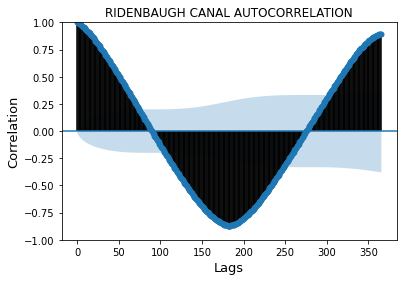

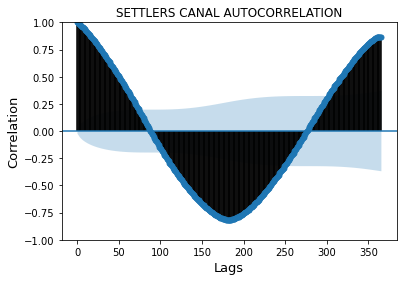

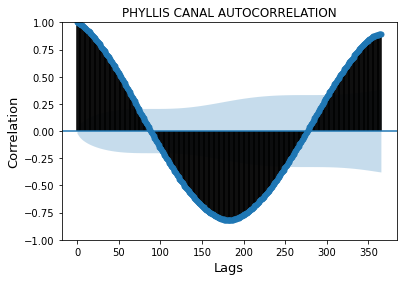

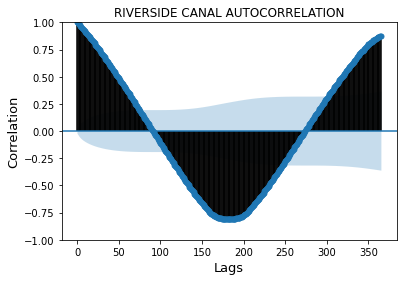

In [ ]:
## Look for autocorrelation in the seasonal component ##

#Run autocorrelation function

acf = []
for i in range(len(canals)):
  irrig = canals[i]
  acf.append(plot_acf(irrig['CFS'], title = irrig['DiversionName'][1]+' CANAL AUTOCORRELATION', lags=365))
  plt.ylabel('Correlation', size=13)
  plt.xlabel('Lags', size=13)
  plt.savefig('datasets/diversion_timeseries/figures/acf'+names[i]+'.png')



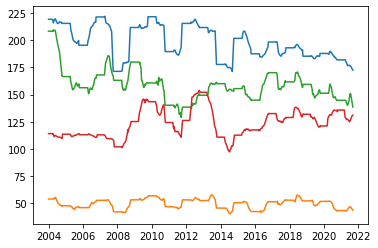

In [ ]:
## DETECT A TREND ##

sma = []

for i in range(len(canals)):
  canal = canals[i]
  sma.append((canal['CFS'].rolling(window=365).mean()))
  plt.plot(sma[i])



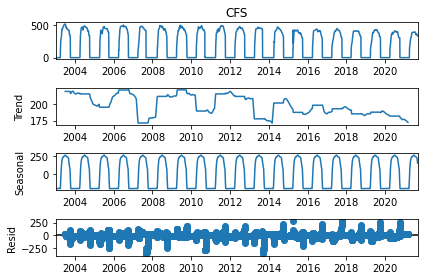

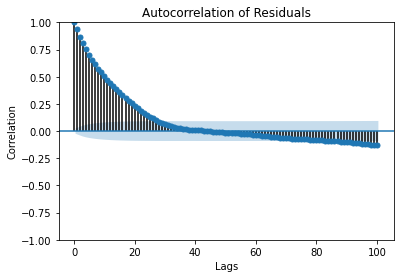

In [ ]:
## Seasonal decomposition of the data ##

rid = canals[0]
decomp = seasonal_decompose(rid['CFS'], model='additive', period=365)
decomp.plot()
plt.show()
resid = decomp.resid
nan_data = np.isnan(resid) #calls the nan values and creates a bool for nan vs number
not_nan_data = ~ nan_data #takes all the "True" values
data = resid[not_nan_data] #uses the location of the true values to create new array with no nan
plot_acf(data, title = 'Autocorrelation of Residuals', lags=100)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [ ]:
## AUTO ARIMA ## 

rid = canals[0]

rid_arima = auto_arima(rid['CFS'], start_p=1, start_q=1, max_p=3, max_q=12,
                       seasonal=True, d=0, seasonal_test='ocsb')

In [ ]:
rid_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6824
Model:               SARIMAX(2, 0, 4)   Log Likelihood              -29347.905
Date:                Mon, 29 Nov 2021   AIC                          58711.811
Time:                        22:59:22   BIC                          58766.436
Sample:                             0   HQIC                         58730.658
                               - 6824                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0429      0.029      1.475      0.140      -0.014       0.100
ar.L1          1.9889      0.013    148.293      0.000       1.963       2.015
ar.L2         -0.9892      0.013    -74.531      0.000      -1.015      -0.963
ma.L1         -0.9111      0.013    -68.574      0.000      -0.937      -0.885
ma.L2         -0.0527      0.019     -2.812      0.005      -0.089      -0.016
ma.L3          0.0030      0.024      0.128      0.898      -0.043       0.050
ma.L4         -0.0202      0.017     -1.193      0.233      -0.053       0.013
sigma2       318.0243      2.100    151.461      0.000     313.909     322.140
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):          18199916.17
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                           -11.41
Prob(H) (two-sided):                  0.00   Kurtosis:                       254.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""